# Simulating Deuteron $H_3$ with XACC-VQE
To run this problem via docker, run the following from an empty directory

```bash
$ docker run --name xacc-notebook -it -p 8888:8888 -d -v $(pwd):/home/notebooks xacc/xacc-all-gate-jupyter-fc26
$ (to see jupyter notebook URL) docker logs xacc-notebook
```

## Import necessary libraries, create the Hamiltonian and Ansatz Circuits

In [5]:
import sys
sys.path.append('/usr/local/xacc/lib/python')
import numpy as np
import pyxacc as xacc
from pyxacc import InstructionParameter
import pyxaccvqe as vqe
from pyxaccvqe import PauliOperator
%matplotlib inline

xacc.Initialize(['--compiler','quil'])

# Specify the Accelerator to run on, 
# default to TNQVM MPS simulator
qpuName = 'tnqvm'
qpu = xacc.getAccelerator(qpuName)
errorMitigation = ['correct-readout-errors']
logicalToPhysicalQubitMapping = [0,1,2]
nQubits = max(logicalToPhysicalQubitMapping) + 1

# Construct the H2 Hamiltonian (see Eq 4 of paper)
H2 = PauliOperator(5.906709445) + \
    PauliOperator({0:'X',1:'X'}, -2.1433) + \
    PauliOperator({0:'Y',1:'Y'}, -2.1433) + \
    PauliOperator({0:'Z'}, .21829) + \
    PauliOperator({1:'Z'}, -6.125)

# Construct H3 Hamiltonian (see Eq 5 of paper)
H3 = H2 + PauliOperator(9.625) + \
    PauliOperator({1:'X',2:'X'}, -3.913119) + \
    PauliOperator({1:'Y',2:'Y'}, -3.913119) + \
    PauliOperator({2:'Z'}, -9.625)

# Code up and compile the H3 ansatz in Quil
srcH3 = """__qpu__ ansatz(AcceleratorBuffer, double t0, double t1) {
X 0
RY(t0) 2
CNOT 2 0
RY(t1) 1
CNOT 0 1
RY(-t1) 1
CNOT 0 1
CNOT 1 0
}"""
ansatzH3 = xacc.Program(qpu, srcH3).getKernel('ansatz').getIRFunction()
print(H3)

(-2.1433,0) X0 X1 + (-2.1433,0) Y0 Y1 + (15.5317,0) + (-9.625,0) Z2 + (0.21829,0) Z0 + (-3.91312,0) Y1 Y2 + (-6.125,0) Z1 + (-3.91312,0) X1 X2


## Parameter Sweep

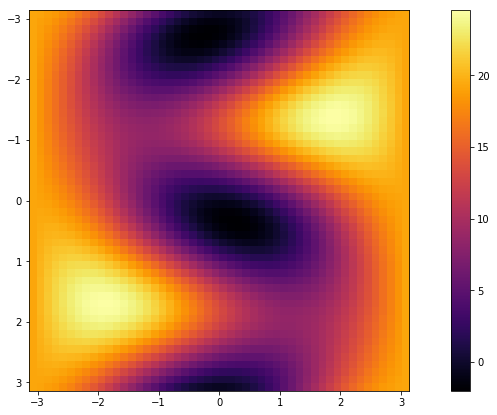

In [2]:
#Compute the H3 energy grid
angle_range = np.linspace(-np.pi,np.pi,50)
energiesH3 = [[vqe.execute(H3, **{'task':'compute-energy',
                                  'vqe-params':str(t0)+','+str(t1), 
                                  'ansatz':ansatzH3,
                                  'error-mitigation':errorMitigation, 
                                  'qubit-map':logicalToPhysicalQubitMapping}).energy 
            for t0 in angle_range] for t1 in angle_range]

import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))
import matplotlib
cmap = matplotlib.cm.get_cmap('inferno')  # this loads the cubehelix color map which prints well in b/w 
ax = plt.subplot()
plt.imshow(energiesH3,interpolation='nearest',cmap=cmap,extent=(
    angle_range.min(),angle_range.max(),angle_range.max(),angle_range.min()))
ax.set_xlabel=r'$\alpha_1'
ax.set_ylabel=r'$\alpha_2'
plt.xlabel=r'$\alpha_1'
plt.ylabel=r'$\alpha_2'
plt.colorbar()
plt.show()

## VQE Routine

In [4]:

vqeResultH3 = vqe.execute(H3, **{'task':'vqe', 'ansatz':ansatzH3, 
                                 'error-mitigation':errorMitigation, 
                                 'qubit-map':logicalToPhysicalQubitMapping})
print('(Optimal Angle, Energy) = (', vqeResultH3.angles, ',', vqeResultH3.energy, ')')
print('Number of QPU Calls = ', vqeResultH3.nQpuCalls)
print('Number of VQE Iterations = ', vqeResultH3.vqeIterations)


(Optimal Angle, Energy) = ( [6.02638641 3.50072523] , -2.0456658659361446 )
Number of QPU Calls =  490
Number of VQE Iterations =  70
